# Train a convolutional neural network

In [1]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


## Import libraries

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 13 19:35:11 2019

@author: hippolyte
"""

import os
import h5py
import imgaug.augmenters as iaa
import numpy as np
import tensorflow as tf
import imgaug as aug
import datetime
import pickle

from keras.applications import vgg16, vgg19, xception
from keras.models import Model, Sequential, load_model, save_model
from keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.engine import InputLayer

from matplotlib import pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

Using TensorFlow backend.


## Global variables

In [0]:
################################################################################
### MODIFIABLE VARIABLES
################################################################################
ROOT_PATH = 'drive/My Drive/master1/medical_image_recognition/'
DATASET_NAME = 'chest_xray'
IMAGE_EXTENSIONS = ['*.jpg', '*.jpeg']

################################################################################
### DON'T CHANGE THESE VARIABLES
################################################################################
DATASET_PATH = ROOT_PATH + 'datasets/' + DATASET_NAME + '/'
ARRAY_PATH   = ROOT_PATH + 'arrays/'   + DATASET_NAME + '/'
MODEL_PATH   = ROOT_PATH + 'models/'   + DATASET_NAME + '/'
# create the directory to save arrays if it doesn't exist
#! mkdir -pv ARRAY_PATH, MODEL_PATH

# get directories and labels
DIRECTORIES = sorted([d for d in os.listdir(DATASET_PATH)])
LABELS = sorted(os.listdir(DATASET_PATH + DIRECTORIES[0]))
# helpers for labels
NUM_LABELS = len(LABELS)
LABEL_MAPPING = {label: code for code, label in enumerate(LABELS)}
# helper for paths
PATHS = {directory: DATASET_PATH + directory + '/' for directory in DIRECTORIES}

In [4]:
print(DIRECTORIES)
print(LABELS)
print(LABEL_MAPPING)

['test', 'train', 'val']
['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


## Fix seeds to have reproducible results

https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

In [0]:
# the next instructions are used to make results reproducible
SEED = 1234
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
tf.set_random_seed(SEED)
aug.seed(SEED)

## Data function

In [0]:
def label_code_to_str(label_code: int) -> str:
    """
    TODO
    """
    for label, code in LABEL_MAPPING.items():
        if label_code == code:
            return label

    raise ValueError('Couldn\'t find the code {} in labels'.format(label_code))

def get_data_dir(directory: str,
                 array_dir: str,
                 height: int=224,
                 width: int=224,
                 channels: int=3):
    """
    TODO
    """
    shape_str = '({},{},{})'.format(height, width, channels)
    filename = array_dir + directory + shape_str + '.h5'
    print('Getting {} images from {}'.format(shape_str, filename))
    
    # some helper variables
    start = datetime.datetime.now()
    
    with h5py.File(filename, 'r') as file:
        # assuming the file contains same amount of image and labels
        num_images = np.ceil(len(file.keys()) / 2).astype(int)

        # define arrays holding data and labels
        data = np.zeros((num_images, height, width, channels), dtype=np.float32)
        labels = np.zeros((num_images, NUM_LABELS), dtype=np.float32)

        # iterate over all images
        # format is x0 y0 for the first image and so on
        for image_index in range(num_images):
            image = file['x' + str(image_index)]
            label = file['y' + str(image_index)]

            data[image_index] = image
            labels[image_index] = label

    # shapes
    print('Data shape : {}\nLabels shape : {}'.format(data.shape, labels.shape))
    
    end = datetime.datetime.now()
    print('Found {} images in {} seconds.'.format(data.shape[0],
                                                 (end-start).seconds))
    
    return data, labels

## Convolutional Neural Network functions

### Create the network

In [0]:
def build_model(input_shape=(224, 224, 3)):
    input_img = Input(shape=input_shape, name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(NUM_LABELS, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    
    loss_type = 'binary' if NUM_LABELS == 2 else 'categorical'
    loss_type += '_crossentropy'
    optimizer = Adam(lr=1e-6, decay=1e-5)
    
    model.compile(loss=loss_type,
                  metrics=['accuracy'],
                  optimizer=optimizer)
    
    return model

### Training function

In [0]:
def train_model(model,
                train_data,
                train_labels,
                val_data,
                val_labels,
                epoch=50,
                batch_size=32,
                metric='val_loss',
                save_best_only=True,
                save_model_path=None,
                save_weights_only=True,
                stop_after=10,
                save_history=True,
                save_history_path=None,
                class_weight_mapping=None):
    """
    TODO
    """
    # callbacks
    early_stopping = EarlyStopping(patience=stop_after,
                                   monitor=metric,
                                   restore_best_weights=True)
    
    checkpoint = ModelCheckpoint(save_model_path,
                                 monitor=metric,
                                 verbose=1,
                                 save_best_only=save_best_only,
                                 save_weights_only=save_weights_only)

    # here we are, we'll train the model
    history = model.fit(x=train_data,
                        y=train_labels,
                        batch_size=batch_size,
                        epochs=epoch,
                        verbose=1,
                        callbacks=[early_stopping, checkpoint],
                        validation_split=0.0,
                        validation_data=(val_data, val_labels),
                        shuffle=True,
                        class_weight=class_weight_mapping)

    # save history
    if save_history:
        with open(save_history_path, 'wb') as file:
            pickle.dump(history.history, file)
        print('\n\nSaved history into {}'.format(save_history_path))
    
    return model, history

### Plot results of the network

In [0]:
def plot_model_performance(model,
                           test_data,
                           test_labels,
                           batch_size=16):
    """
    TODO
    """
    print('Performances for {} model.'.format(model.name))
    print('\n\n')
    test_loss, test_score = model.evaluate(test_data,
                                           test_labels,
                                           batch_size=16)
    print('Loss : {}'.format(test_loss))
    print('Score : {}'.format(test_score))
    print('\n\n')

    # predictions and groud truth
    preds = model.predict(test_data, batch_size=16)
    preds = np.argmax(preds, axis=-1)
    ground_truth = np.argmax(test_labels, axis=-1)
    
    # confusion matrix
    cm  = confusion_matrix(ground_truth, preds)
    
    # metrics
    recall = np.diag(cm) / np.sum(cm, axis=1)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    accuracy = np.diag(cm) / np.sum(cm)

    print('Recall : {}'.format(recall))
    print('Precision : {}'.format(precision))
    print('Accuracy : {}'.format(accuracy))
    print('\n\n')

    # plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cm,
                          figsize=(12, 8),
                          cmap=plt.cm.Blues)
    plt.xticks(range(NUM_LABELS), LABELS) #, fontsize=16)
    plt.yticks(range(NUM_LABELS), LABELS) #, fontsize=16)
    plt.show()
    
    return preds
    
def plot_model_history(history_path):
    """
    TODO
    """
    print('Loading history from {}'.format(history_path))
    history = pickle.load(open(history_path, 'rb'))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4)) #, constrained_layout=True)

    # accuracy
    axes[0].plot(history['acc'])
    axes[0].plot(history['val_acc'])
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend(['train', 'val'])

    # loss
    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend(['train', 'val'])
    plt.show()

## Let's do it !

### Data part

Getting (224,224,3) images from drive/My Drive/master1/medical_image_recognition/arrays/chest_xray/test(224,224,3).h5
Data shape : (624, 224, 224, 3)
Labels shape : (624, 2)
Found 624 images in 5 seconds.
1(PNEUMONIA)


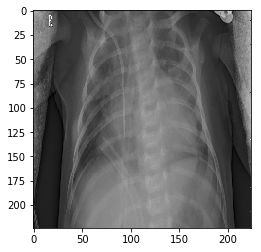

Getting (224,224,3) images from drive/My Drive/master1/medical_image_recognition/arrays/chest_xray/train(224,224,3).h5
Data shape : (5221, 224, 224, 3)
Labels shape : (5221, 2)
Found 5221 images in 41 seconds.
1(PNEUMONIA)


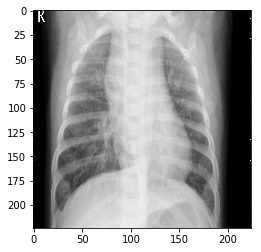

Getting (224,224,3) images from drive/My Drive/master1/medical_image_recognition/arrays/chest_xray/val(224,224,3).h5
Data shape : (16, 224, 224, 3)
Labels shape : (16, 2)
Found 16 images in 0 seconds.
0(NORMAL)


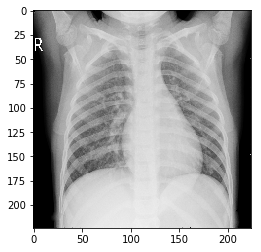

In [11]:
HEIGHT, WIDTH, CHANNELS = 224, 224, 3

data, labels = dict(), dict()

for directory in DIRECTORIES:
    # get data and labels
    data[directory], labels[directory] = get_data_dir(directory,
                                                      array_dir=ARRAY_PATH,
                                                      height=HEIGHT,
                                                      width=WIDTH,
                                                      channels=CHANNELS)
    
    # get a random index
    ind = np.random.randint(data[directory].shape[0])

    # plot the image with label
    plt.imshow(data[directory][ind])
    img_label = np.argmax(labels[directory][ind])
    img_label_str = label_code_to_str(img_label)
    #plt.title(img_label_str, img_label)
    print('{}({})'.format(img_label, img_label_str))
    plt.show()

### CNN creation

In [12]:
model = build_model(input_shape=(HEIGHT, WIDTH, CHANNELS))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### CNN training
#### USE IT WITH CAUTION, IT CAN TAKE TIME

In [13]:
import pandas as pd
import math
df = pd.DataFrame(labels['train'])
d = dict(df[0].value_counts())
print(d)

{0.0: 3875, 1.0: 1346}


In [14]:
print(d[1] / d[0])

0.3473548387096774


In [0]:
CLASS_WEIGHT_MAPPING = {0: 3., 1: 1.}

In [16]:
SAVE_MODEL_PATH = MODEL_PATH + model.name + '_model.hdf5'
SAVE_HISTORY_PATH = MODEL_PATH + model.name + '_history'

model, history = train_model(model,
                             train_data=data['train'],
                             train_labels=labels['train'],
                             val_data=data['test'],
                             val_labels=labels['test'],
                             epoch=200,
                             batch_size=32,
                             metric='val_acc',
                             save_best_only=True,
                             save_model_path=SAVE_MODEL_PATH,
                             save_weights_only=False,
                             stop_after=25,
                             save_history=True,
                             save_history_path=SAVE_HISTORY_PATH,
                             class_weight_mapping=CLASS_WEIGHT_MAPPING)

Instructions for updating:
Use tf.cast instead.
Train on 5221 samples, validate on 624 samples
Epoch 1/200
5221/5221 [==============================] - 179s 34ms/step - loss: 1.0505 - acc: 0.5221 - val_loss: 0.6931 - val_acc: 0.4135

Epoch 00001: val_acc improved from -inf to 0.41346, saving model to drive/My Drive/master1/medical_image_recognition/models/chest_xray/model_1_model.hdf5
Epoch 2/200
5221/5221 [==============================] - 169s 32ms/step - loss: 1.0501 - acc: 0.6411 - val_loss: 0.6927 - val_acc: 0.8429

Epoch 00002: val_acc improved from 0.41346 to 0.84295, saving model to drive/My Drive/master1/medical_image_recognition/models/chest_xray/model_1_model.hdf5
Epoch 3/200
5221/5221 [==============================] - 169s 32ms/step - loss: 1.0488 - acc: 0.8198 - val_loss: 0.6916 - val_acc: 0.8365

Epoch 00003: val_acc did not improve from 0.84295
Epoch 4/200
5221/5221 [==============================] - 169s 32ms/step - loss: 1.0454 - acc: 0.8391 - val_loss: 0.6884 - val_a

In [0]:
preds = plot_model_performance(model,
                               test_data=data['test'],
                               test_labels=labels['test'],
                               batch_size=32)

In [0]:
plot_model_history(SAVE_HISTORY_PATH)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(labels['test'], axis=-1),
                            preds,
                            target_names=LABELS))